# Dealing with missing data

[**Alex Williams**](http://alexhwilliams.info)

The [Netflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize) is a famous competition in contemporary machine learning. The high-level purpose of the competition was to develop algorithms to make movie suggestions to Neflix users given their ratings (on a 1-5 scale) of movies they watched.

For us, we will simply view this as a problem of [matrix completion](https://en.wikipedia.org/wiki/Matrix_completion). That is, we have a matrix of data $A$, with many observed entries, but also many missing entries. These entries will be marked $A_{ij} = \text{NA}$; which is read aloud as `"Not Available"`. In the case of the Netflix dataset, each row of $A$ is a different Netflix user, and each column of $A$ is a different movie available on Netflix. Each user only has time to view and rate a subset of the movies, so many entries are $\text{NA}$. However, we would like to guess the rating each user *would have given* a movie, had he or she watched it. If we think they are likely to have rated a movie highly, then we should reccomend that they watch it.

### Outline for this paper

* Outline of applications

    * Collaborative filtering -- people are less likely to rate something they think they'll hate
    
    * Single-cell RNA-seq -- forget about the transcriptional bursting problem. Undetected genes are likely to be lowly expressed, but might be present below the detection threshold.
    
    * Medical informatics -- a test on a patient is less likely to be run if the doctor thinks it will come back negative
    
    * Censoring -- for example, a dataset where rich people are less likely to disclose their earnings

* Theoretical analysis

    * How to choose the regularization penalty? Cross-validation?

In [1]:
using LowRankModels
import DataFrames: @data,NA
using DataArrays
using PyPlot
include("utils/glrm_extensions.jl")

  likely near /Users/alex/.julia/v0.4/MLBase/src/modeltune.jl:5
  likely near /Users/alex/.julia/v0.4/MLBase/src/modeltune.jl:5
  likely near /Users/alex/.julia/v0.4/MLBase/src/modeltune.jl:5
  likely near /Users/alex/.julia/v0.4/MLBase/src/deprecated/datapre.jl:104
  likely near /Users/alex/.julia/v0.4/MLBase/src/deprecated/datapre.jl:105
  likely near /Users/alex/.julia/v0.4/MLBase/src/deprecated/datapre.jl:163
  likely near /Users/alex/.julia/v0.4/MLBase/src/deprecated/datapre.jl:163
  likely near /Users/alex/.julia/v0.4/MLBase/src/deprecated/datapre.jl:163


SimplexOneReg

### Construct synthetic dataset (Boolean data, `-1` more likely to be missing than `+1`)

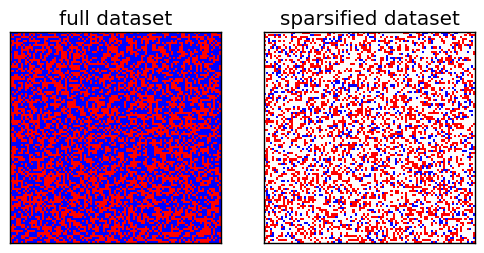

PyObject <matplotlib.text.Text object at 0x310a2b4d0>

In [2]:
m,n,k = 100,100,10
lgc(x) = 1.0 ./ (1.0 + exp(-x))
P = lgc(randn(m,k)*randn(k,n)) # probabilities
A_full = @data(Array(Int,m,n))
for i = 1:m
    for j = 1:n
        if rand() < P[i,j]
            A_full[i,j] = 1
        else
            A_full[i,j] = -1
        end
    end
end

# Stochastically remove entries
null_sparsity = 0.8 # proportion of unobserved -1
one_sparsity = 0.4  # proportion of unobserved +1

# Build an incomplete matrix of observed data
A = deepcopy(A_full)
for i = 1:m
    for j = 1:n
        if ( (A_full[i,j] == 1)  && (rand() < one_sparsity)  )
            A[i,j] = NA
        elseif ( (A_full[i,j] == -1) && (rand() < null_sparsity) )
            A[i,j] = NA
        end
    end
end

figure(figsize=(6,3))
subplot(1,2,1)
imshow(convert(Array,A_full,0),interpolation="none",cmap=ColorMap("bwr"))
xticks([]); yticks([]); title("full dataset")
subplot(1,2,2)
imshow(convert(Array,A,0),interpolation="none",cmap=ColorMap("bwr"))
xticks([]); yticks([]); title("sparsified dataset")

### Helper Functions.

In [3]:
# Fit logistic PCA, assuming unobserved values are likely "-1".
# Because we are uncertain about the true value of the missing entries, we
# penalize these errors with a weaker quadratic penalty (set by the na_scale parameter).
function fit_naloss_pca(A;obs_scale=1.0,na_scale=0.1)
    loss = NALoss(LogLoss(obs_scale), LogLoss(na_scale), -1)
    r = QuadReg()
    glrm = GLRM(A,loss,r,r,k;checknan=false)
    X,Y,ch = fit!(glrm,verbose=false)
    return X,Y,lgc(X'*Y)
end

# Helper function to plot results
function plot_reconstruction(A_reconstruct)
    figure(figsize=(6,3))
    subplot(1,2,1)
    imshow(convert(Array,A_full,0),interpolation="none",cmap=ColorMap("bwr"))
    xticks([]); yticks([]); title("full dataset")
    subplot(1,2,2)
    imshow(A_reconstruct,interpolation="none",cmap=ColorMap("bwr"))
    xticks([]); yticks([]);
end

plot_reconstruction (generic function with 1 method)

LowRankModels.

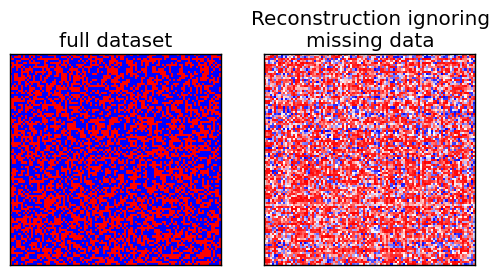

PyObject <matplotlib.text.Text object at 0x30e3c2f50>

ProxGradParams(1.0,100,1,1.0e-5,0.01)


In [4]:
# Classic logistic PCA, ignore missing entries
X,Y,A_reconstruct = fit_naloss_pca(A;na_scale=0.0)
plot_reconstruction(A_reconstruct)
title("Reconstruction ignoring\nmissing data")

LowRankModels.

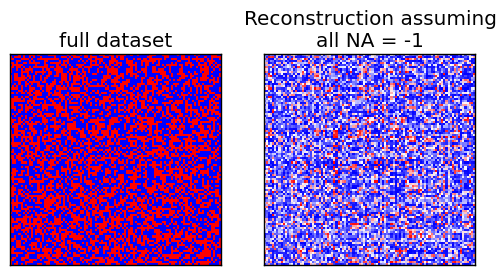

PyObject <matplotlib.text.Text object at 0x311103c50>

ProxGradParams(1.0,100,1,1.0e-5,0.01)


In [5]:
# Logistic PCA, assuming missing entries are -1
X,Y,A_reconstruct = fit_naloss_pca(A;na_scale=1.0)
plot_reconstruction(A_reconstruct)
title("Reconstruction assuming\nall NA = -1")

LowRankModels.

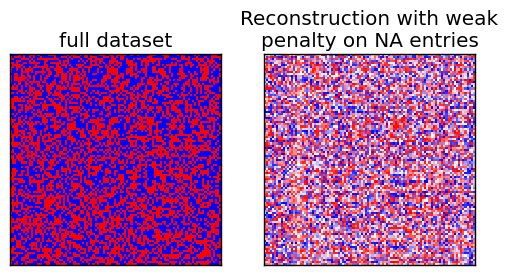

PyObject <matplotlib.text.Text object at 0x311304390>

ProxGradParams(1.0,100,1,1.0e-5,0.01)


In [6]:
# Logistic PCA, assuming NA=-1, weaker penalty on imputed entries
X,Y,A_reconstruct = fit_naloss_pca(A;na_scale=0.1)
plot_reconstruction(A_reconstruct)
title("Reconstruction with weak\npenalty on NA entries")

## How to choose a reasonable value for `na_scale`?

Oracle:

In [ ]:
function calc_oracle_error(A_reconstruct)
    
end